### EDA

All results in EDA part have been discussed in the final report.

In [1]:
import os
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\gpu_tf\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
EPOCHS = 300
SAMPLE_LEN = 100
IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [4]:
train_data

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [5]:
test_data

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


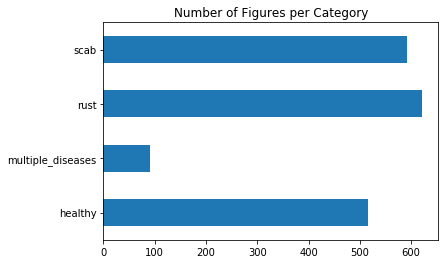

In [6]:
train_data.loc[:,'healthy':'scab'].sum().plot(kind='barh')
plt.title('Number of Figures per Category');

In [14]:
# We use SMOTE to oversample our data
from imblearn.over_sampling import SMOTE 

In [8]:
def format_path(st):
    return './plant-pathology-2020-fgvc7' + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, 
                                                                        test_size=0.15, random_state=2020)

In [13]:
# The original image is too large, we choose not to run it.
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#original = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)
#sample1 = px.imshow(original[0])
#sample1.show()

In [10]:
img_size = 100
train_image=[]
for path in train_paths:
    img = cv2.imread(path)
    image = cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    train_image.append(image)

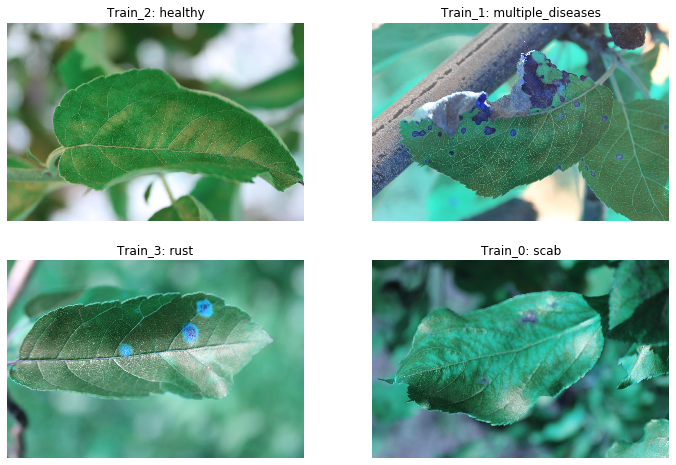

In [11]:
disease = ['healthy','multiple_diseases','rust','scab']
plt.figure(figsize=(12,8))
i = 0
for col in disease:
    plt.subplot(2,2,i+1)
    image_id = train_data[train_data[col] == 1]['image_id'].iloc[0]
    img = cv2.imread('./plant-pathology-2020-fgvc7' + '/images/' + image_id + '.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_id + ': ' + col)
    i += 1

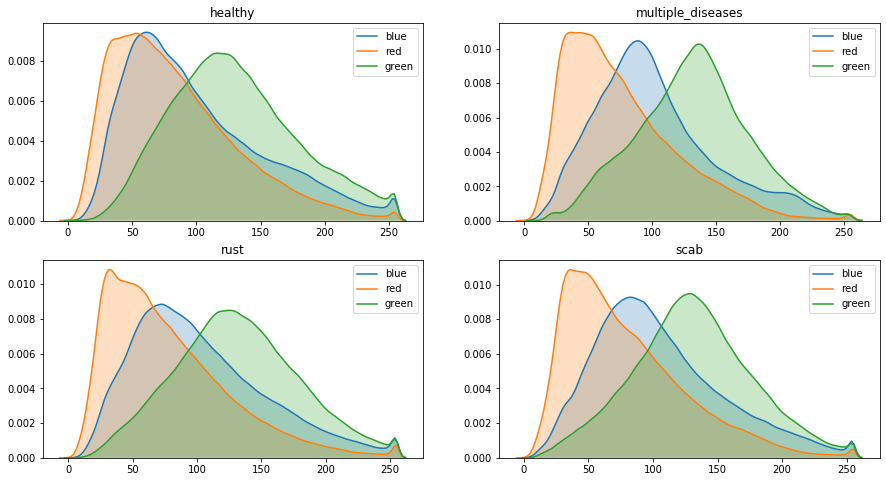

In [12]:
channels = ['red',  'green', 'blue']
disease = ['healthy','multiple_diseases','rust','scab']
plt.figure(figsize=(15,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    for ch in [2,0,1]:
        chan = []
        for j in np.where(train_labels[:,i])[0]:
            chan.append(train_image[j][:,:,ch].ravel())
        sns.kdeplot(np.vstack(chan).ravel(), label=channels[ch], shade=True)
    plt.title(disease[i])